<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>Evaluation</h1> 
</div>


<p>
Following Section 4.5 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss some general evaluation metrics that are the basis for evaluating music processing tasks. A comprehensive Python library that provides implementations for measures to evaluate Music Information Retrieval systems is provided by the <code>mir_eval</code> toolbox:

<ul>
<li><span style="color:black">
Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, Daniel P. W. Ellis:<a href="https://colinraffel.com/publications/ismir2014mir_eval.pdf"><strong> MIR_EVAL: A Transparent Implementation of Common MIR Metrics.</strong></a> Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), Taipei, Taiwan, 2014, pp. 367&ndash;372.
<br>
    <a href="https://craffel.github.io/mir_eval/">Documentation</a>
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_RaffelMHSNLE14_MIReval_ISMIR.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 

## Introduction

We have described various procedures for extracting structural information from a given music recording. However, we have not yet discussed the issue of measuring **how well** a given procedure performs the task at hand. The problem of of (automatically) evaluating music processing algorithms goes far beyond structure analysis and itself constitutes a nontrivial task. A general evaluation approach is to compare an **estimated result** obtained by some automated procedure against some **reference result**. To realize such a general approach, one needs to find answers to the following questions: 

* How is a given analysis result actually modeled?
* How should the estimated result be compared against the reference result? 
* Where does the reference result come from and is it reliable?

In particular the last question easily leads to philosophical considerations on the nature and meaning of musical descriptions. For example, music structure analysis is an ill-posed problem that depends on many different factors, not to mention the musical and acoustic variations that occur in real-world music recordings. Since analysis results largely depend on the musical context and the considered temporal level, even two human experts may disagree in their analysis of a given piece of music. In the case of our Brahms example, one expert may annotate the structure on a larger scale resulting in the musical structure $A_1A_2B_1B_2CA_3B_3B_4D$, while another expert may consider a  smaller scale, where the parts are further subdivided. In the following code cell, we give examples of annotations on three different scales.

<!--<img src="../data/C4/FMP_C4_F28.png" width="300px" align="middle" alt="FMP_C4_F28">-->

In practice, one typically assumes that a valid reference structure annotation has been provided by a human expert, even though this is a simplistic and sometimes problematic assumption. Such an annotation is also often referred to as **ground truth**. The objective of the automated procedure is to estimate an annotation that is as close to the reference as possible. 

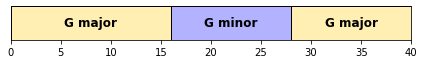

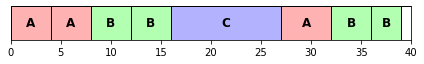

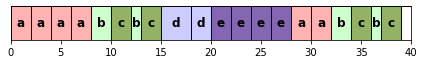

In [1]:
import os, sys, librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sys.path.append('..')
import libfmp.b
from libfmp.b import FloatingBox
import libfmp.c4
%matplotlib inline

ann_Brahms = {}
ann_Brahms[0] = [[0, 16, 'G major'], [16, 28, 'G minor'], [28, 40, 'G major']]

ann_Brahms[1] = [[0, 4, 'A'], [4, 8, 'A'],  [8, 12, 'B'], [12, 16, 'B'],
                [16, 27, 'C'], [27, 32, 'A'], [32, 36, 'B'], [36, 39, 'B'], [39, 40, '']]

ann_Brahms[2] = [[0, 2, 'a'], [2, 4, 'a'], [4, 6, 'a'], [6, 8, 'a'],
                [8, 10, 'b'], [10, 12, 'c'], [12, 13, 'b'], [13, 15, 'c'],
                [15, 18, 'd'], [18, 20, 'd'], 
                [20, 22, 'e'], [22, 24, 'e'], [24, 26, 'e'], [26, 28, 'e'],
                [28, 30, 'a'], [30, 32, 'a'], 
                [32,34, 'b'], [34, 36, 'c'], [36, 37, 'b'], [37, 39, 'c'], [39, 40, '']]

color_ann_Brahms = {'G major': [1, 0.8, 0, 0.3], 'G minor': [0, 0, 1, 0.3],
    'A': [1, 0, 0, 0.3], 'B': [0, 1, 0, 0.3], 'C': [0, 0, 1, 0.3], '': [1, 1, 1, 0.3],
    'a': [1, 0, 0, 0.3], 'b': [0, 1, 0, 0.2], 'c': [0.3, 0.5, 0, 0.6], 
    'd': [0, 0, 1, 0.2], 'e': [0.2, 0, 0.5, 0.6],  '': [1, 1, 1, 1]}                    

figsize = (6,1)
for k in range(3):
    libfmp.b.plot_segments(ann_Brahms[k], figsize = figsize, colors=color_ann_Brahms); 

## Precision, Recall, F-Measure

Many evaluation measures are based on some notion of precision, recall, and F-measure&mdash;a concept that has been borrowed from the fields of information retrieval and pattern recognition. We now introduce this general concept in the context of binary classification. First, let $\mathcal{I}$ be a finite set of so-called **items**. For this set, one has a reference annotation that is the result of a binary classification. Each item $i\in \mathcal{I}$ is assigned either a label '$+$' (item is **positive** or **relevant**) or a label '$-$'  (item is **negative** or **not relevant**). Let $\mathcal{I}^\mathrm{Ref}_+$ be the set of positive items, and $\mathcal{I}^\mathrm{Ref}_-$ be the set of negative items. Furthermore, one has an automated procedure that estimates the annotation for each item. Let $\mathcal{I}^\mathrm{Est}_+$ be the set of items being estimated as positive, and $\mathcal{I}^\mathrm{Est}_-$ be the set of items being estimated as negative. An item $i\in\mathcal{I}^\mathrm{Est}_+$ estimated as positive is called a **true positive** (TP) if it belongs to $\mathcal{I}^\mathrm{Ref}_+$, i.e., if $i\in\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+$. Otherwise, if $i\in\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_-$, it is called a **false positive** (FP). Similarly, an item $i\in\mathcal{I}^\mathrm{Est}_-$ estimated as negative is called a **false negative** (FN) if it belongs to $\mathcal{I}^\mathrm{Ref}_+$, and **true negative** (TN) otherwise.

The **precision** $\mathrm{P}$ of the estimation is defined as the number of true positives divided by the total number of items estimated as positive:

\begin{equation}
   \mathrm{P} = \frac{|\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+|}{|\mathcal{I}^\mathrm{Est}_+|} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FP}}.  
\end{equation}

In contrast, the **recall** $\mathrm{R}$ is defined as the number of true positives divided by the total number of positive items:

\begin{equation}
   \mathrm{R} = \frac{|\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+|}{|\mathcal{I}^\mathrm{Ref}_+|} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FN}}.  
\end{equation}

Note that both precision and recall have values in the interval $[0,1]$. A perfect precision $\mathrm{P}=1$ means that every item estimated as positive is indeed positive. In this case, there is no false positive, but there may exist some false negatives. In contrast, a perfect recall $\mathrm{R}=1$ means that every positive item was also estimated as positive. In this case, there is no false negative, but there may exist some false positives. Only in the case $\mathrm{P}=1$ and $\mathrm{R}=1$ does the estimated annotation coincide with the reference annotation. Precision and recall are often combined by taking their **harmonic mean** to form a single measure, often referred to as the **F-measure**:

\begin{equation}
   \mathrm{F} = \frac{2\cdot \mathrm{P}\cdot \mathrm{R}}{\mathrm{P} + \mathrm{R}}.  
\end{equation}

One main property is that $\mathrm{F}\in[0,1]$ with $\mathrm{F}=1$ if and only if $\mathrm{P}=1$ and $\mathrm{R}=1$. The following figure illustrates the definitions:

<img src="../data/C4/FMP_C4_F29.png" width="500px" align="middle" alt="FMP_C4_F29">


Given the sets $\mathcal{I}$, $\mathcal{I}^\mathrm{Ref}_+$, and $\mathcal{I}^\mathrm{Est}_+$, we provide in the following code cell a function for computing the various measures and give some examples. 

In [2]:
def measure_prf(num_TP, num_FN, num_FP):
    """Compute P, R, and F from size of TP, FN, and FP [FMP, Section 4.5.1]

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        num_TP (int): True positives
        num_FN (int): False negative
        num_FP (int): False positives

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
    """
    P = num_TP / (num_TP + num_FP)
    R = num_TP / (num_TP + num_FN)
    if (P + R) > 0:
        F = 2 * P * R / (P + R)
    else:
        F = 0
    return P, R, F
    

def measure_prf_sets(I, I_ref_pos, I_est_pos, details=False):
    """Compute P, R, and F from sets I, I_ref_pos, I_est_pos [FMP, Section 4.5.1]

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        I: Set of items
        I_ref_pos: Reference set of positive items
        I_est_pos: Set of items being estimated as positive
        details: Print details (Default value = False)

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
    """
    I_ref_neg = I.difference(I_ref_pos)
    I_est_neg = I.difference(I_est_pos)
    TP = I_est_pos.intersection(I_ref_pos)
    FN = I_est_neg.intersection(I_ref_pos)
    FP = I_est_pos.intersection(I_ref_neg)
    P, R, F = measure_prf(len(TP), len(FN), len(FP))
    if details:
        print('TP = ', TP, ';  FN = ', FN, ';  FP = ', FP)
        print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))
    return P, R, F

print('Example 1')
I = {0,1,2,3,4,5,6,7,8,9}
I_ref_pos = {0,1,2,3}
I_est_pos = {0,1,2,4,5}
P, R, F = measure_prf_sets(I, I_ref_pos, I_est_pos, details=True)

Example 1
TP =  {0, 1, 2} ;  FN =  {3} ;  FP =  {4, 5}
P = 0.600;  R = 0.750;  F = 0.667


In [3]:
print('Example 2')
I = {0,1,2,3,4,5,6,7,8,9}
I_ref_pos = {0,1,2,3,4,5,6}
I_est_pos = {0,1,2,7,8,9}
P, R, F = measure_prf_sets(I, I_ref_pos, I_est_pos, details=True)

Example 2
TP =  {0, 1, 2} ;  FN =  {3, 4, 5, 6} ;  FP =  {8, 9, 7}
P = 0.500;  R = 0.429;  F = 0.462


In [4]:
print('Example 3')
I = {0,1,2,3,4,5,6,7,8,9}
I_ref_pos = I
I_est_pos = {0,1,2}
P, R, F = measure_prf_sets(I, I_ref_pos, I_est_pos, details=True)

Example 3
TP =  {0, 1, 2} ;  FN =  {3, 4, 5, 6, 7, 8, 9} ;  FP =  set()
P = 1.000;  R = 0.300;  F = 0.462


## Labeling Evaluation

In the following scenario, we consider a frame-level music analysis task. Let $\varphi:[1:N]$ be the time axis given in frames and let $\Lambda$ a set of possible labels. We define a **label function** to be a function $\varphi:[1:N] \to \Lambda$ that assigns for each frame index $n\in[1:N]$ a label $\varphi(n)\in\Lambda$. We now introduce some frame-based evaluation measures, which are referred to as **pairwise precision**, **pairwise recall**, and **pairwise F-measure**. 

Let $\varphi^\mathrm{Ref}$ and $\varphi^\mathrm{Est}$ be the label functions for the reference and estimated structure annotation, respectively. In order to become independent of the actual label naming, the main idea is to not directly look at the labels, but to look for label co-occurrences. To this end, we consider pairs of frames that are assigned to the same label. More precisely, we define the set

\begin{equation}
   \mathcal{I}=\{(n,m)\in[1:N]\times[1:N]\mid m<n\},
\end{equation}

which serves as a set of items. For the reference and estimated annotations, we define the positive items by 

\begin{eqnarray}
   \mathcal{I}^\mathrm{Ref}_+&=&\{(n,m)\in\mathcal{I}\mid \varphi^\mathrm{Ref}(n)=\varphi^\mathrm{Ref}(m)\},\\
   \mathcal{I}^\mathrm{Est}_+&=&\{(n,m)\in\mathcal{I}\mid \varphi^\mathrm{Est}(n)=\varphi^\mathrm{Est}(m)\},
\end{eqnarray}

whereas $\mathcal{I}^\mathrm{Ref}_-=\mathcal{I}\setminus\mathcal{I}^\mathrm{Ref}_+$ and $\mathcal{I}^\mathrm{Est}_-=\mathcal{I}\setminus\mathcal{I}^\mathrm{Est}_+$. In other words, an item $(n,m)$ is considered to be **positive** with regard to an annotation if the frames $n$ and $m$ have the same label. Now, the **pairwise precision** is defined to be the precision of this binary classification scheme. Similarly, the **pairwise recall** is the recall and the **pairwise F-measure** is the F-measure of this scheme. 

The definitions are illustrated by the following figures. We start with a function that converts a given segment-based structure annotation into a **frame-based label sequence** (encoding a label function $\varphi$). In the following two examples, the sampled time interval consists of $N=10$ samples.

<!--<img src="../data/C4/FMP_C4_F30.png" width="600px" align="middle" alt="FMP_C4_F30">-->

Segment-based structure annotation:


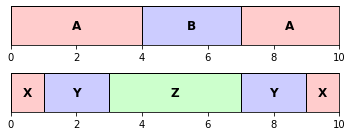

Frame-based label sequence:


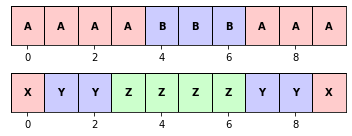

In [5]:
def convert_ann_to_seq_label(ann):
    """Convert structure annotation with integer time positions (given in indices)
    into label sequence

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        ann (list): Annotation (list ``[[s, t, 'label'], ...]``, with ``s``, ``t`` being integers)

    Returns:
        X (list): Sequencs of labels
    """
    X = []
    for seg in ann:
        K = seg[1] - seg[0]
        for k in range(K):
            X.append(seg[2])
    return X

def plot_seq_label(ax, X, Fs=1, color_label=[], direction='horizontal',
                   fontsize=10, time_axis=False, print_labels=True):
    """Plot label sequence in the style of annotations

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        ax: Axis used for plotting
        X: Label sequence
        Fs: Sampling rate (Default value = 1)
        color_label: List of colors for labels (Default value = [])
        direction: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = 'horizontal')
        fontsize: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = 10)
        time_axis: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = False)
        print_labels: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = True)

    Returns:
         ann_X: Structure annotation for label sequence
    """
    ann_X = []
    for m, cur_x in enumerate(X):
        ann_X.append([(m-0.5)/Fs, (m+0.5)/Fs, cur_x])
    libfmp.b.plot_segments(ann_X, ax=ax, time_axis=time_axis, fontsize=fontsize,
                           direction=direction, colors=color_label, print_labels=print_labels)
    return ann_X

color_label = {'A': [1, 0, 0, 0.2], 'B': [0, 0, 1, 0.2], 'C': [0, 1, 0, 0.2],
             'X': [1, 0, 0, 0.2], 'Y': [0, 0, 1, 0.2], 'Z': [0, 1, 0, 0.2]}

ann_ref = [[0, 4, 'A'], [4, 7, 'B'], [7, 10, 'A']]
ann_est = [[0, 1, 'X'], [1, 3, 'Y'], [3, 7, 'Z'], [7, 9, 'Y'], [9, 10, 'X']]

X_ref = convert_ann_to_seq_label(ann_ref)
X_est = convert_ann_to_seq_label(ann_est)

print('Segment-based structure annotation:')
plt.figure(figsize=(5,2))
ax = plt.subplot(211)
libfmp.b.plot_segments(ann_ref, ax=ax, colors=color_label); 
#ax.set_xticks([])
ax = plt.subplot(212)
libfmp.b.plot_segments(ann_est, ax=ax, colors=color_label); 
#ax.set_xticks([])
plt.tight_layout()
plt.show()

print('Frame-based label sequence:')
plt.figure(figsize=(5,2))
ax = plt.subplot(211)
plot_seq_label(ax, X_ref, color_label=color_label, time_axis=True);
ax = plt.subplot(212)
plot_seq_label(ax, X_est, color_label=color_label, time_axis=True);
plt.tight_layout()

Using the first sequence as reference $\varphi^\mathrm{Est}$ and the second one as estimation $\varphi^\mathrm{Est}$, we now illustrate the pairwise precision, recall, and F-measure. In particular, we show the positive items (indicated by gray entries) of the reference and estimated annotations. Furthermore, we visualize true positive (TP), false negative (FN), and false positive (FP) items. 


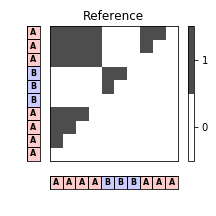
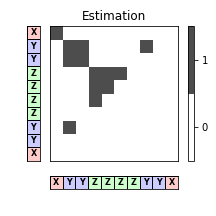
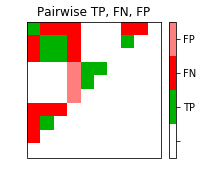

#TP =  10 ;  #FN =  14 ;  #FP =  3
P = 0.769;  R = 0.417;  F = 0.541


In [6]:
def compare_pairwise(X):
    """Compute set of positive items from label sequence [FMP, Section 4.5.3]

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        X (list or np.ndarray): Label sequence

    Returns:
        I_pos (np.ndarray): Set of positive items
    """
    N = len(X)
    I_pos = np.zeros((N, N))
    for n in range(1, N):
        for m in range(n):
            if X[n] is X[m]:
                I_pos[n, m] = 1
    return I_pos

def evaluate_pairwise(I_ref_pos, I_est_pos):
    """Compute pairwise evaluation measures [FMP, Section 4.5.3]

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        I_ref_pos (np.ndarray): Referenence set of positive items
        I_est_pos (np.ndarray): Set of items being estimated as positive

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
        I_eval (np.ndarray): Data structure encoding TP, FN, FP
    """
    I_eval = np.zeros(I_ref_pos.shape)
    TP = (I_ref_pos + I_est_pos) > 1
    FN = (I_ref_pos - I_est_pos) > 0
    FP = (I_ref_pos - I_est_pos) < 0
    I_eval[TP] = 1
    I_eval[FN] = 2
    I_eval[FP] = 3
    num_TP = np.sum(TP)
    num_FN = np.sum(FN)
    num_FP = np.sum(FP)
    P, R, F = measure_prf(num_TP, num_FN, num_FP)
    return P, R, F, num_TP, num_FN, num_FP, I_eval

def plot_matrix_label(M, X, color_label=None, figsize=(3, 3), cmap='gray_r', fontsize=8, print_labels=True):
    """Plot matrix and label sequence

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        M: Matrix
        X: Label sequence
        color_label: List of colors for labels (Default value = None)
        figsize: Figure size (Default value = (3, 3))
        cmap: Colormap for imshow (Default value = 'gray_r')
        fontsize: Font size (Default value = 8)
        print_labels: Display labels inside Rectangles (Default value = True)

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    fig, ax = plt.subplots(2, 3, gridspec_kw={'width_ratios': [0.1, 1, 0.05],
                                              'wspace': 0.2, 'height_ratios': [1, 0.1]},
                           figsize=figsize)

    colorList = np.array([[1, 1, 1, 1],  [0, 0, 0, 0.7]])
    cmap = ListedColormap(colorList)
    im = ax[0, 1].imshow(M, aspect='auto', cmap=cmap,  origin='lower', interpolation='nearest')
    im.set_clim(vmin=-0.5, vmax=1.5)
    ax_cb = plt.colorbar(im, cax=ax[0, 2])
    ax_cb.set_ticks(np.arange(0, 2, 1))
    ax_cb.set_ticklabels(np.arange(0, 2, 1))
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    plot_seq_label(ax[1, 1], X, color_label=color_label, fontsize=fontsize, print_labels=print_labels)
    ax[1, 2].axis('off')
    ax[1, 0].axis('off')
    plot_seq_label(ax[0, 0], X, color_label=color_label, fontsize=fontsize, print_labels=print_labels,
                   direction='vertical')
    return fig, ax

def plot_matrix_pairwise(I_eval, figsize=(3, 2.5)):
    """Plot matrix I_eval encoding TP, FN, FP (see :func:`libfmp.c4.c4s5_evaluation.evaluate_pairwise`)

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        I_eval: Data structure encoding TP, FN, FP
        figsize: Figure size (Default value = (3, 2.5))

    Returns:
        fig: Handle for figure
        im: Handle for imshow
    """
    fig = plt.figure(figsize=figsize)
    colorList = np.array([[1, 1, 1, 1], [0, 0.7, 0, 1], [1, 0, 0, 1], [1, 0.5, 0.5, 1]])
    cmap = ListedColormap(colorList)
    im = plt.imshow(I_eval, aspect='auto', cmap=cmap,  origin='lower', interpolation='nearest')
    im.set_clim(vmin=-0.5, vmax=3.5)
    plt.xticks([])
    plt.yticks([])
    ax_cb = plt.colorbar(im)
    ax_cb.set_ticks(np.arange(0, 4, 1))
    ax_cb.set_ticklabels(['', 'TP', 'FN', 'FP'])
    return fig, im

float_box = libfmp.b.FloatingBox(align='top')
I_ref_pos = compare_pairwise(X_ref)
fig, ax = plot_matrix_label(I_ref_pos, X_ref, color_label=color_label)
ax[0,1].set_title('Reference')
float_box.add_fig(fig)

I_est_pos = compare_pairwise(X_est)
fig, ax = plot_matrix_label(I_est_pos, X_est, color_label=color_label)
ax[0,1].set_title('Estimation')
float_box.add_fig(fig)

P, R, F, num_TP, num_FN, num_FP, I_eval =  evaluate_pairwise(I_ref_pos, I_est_pos)
fig, im = plot_matrix_pairwise(I_eval)
plt.title('Pairwise TP, FN, FP')
float_box.add_fig(fig)
float_box.show()

print('#TP = ', num_TP, ';  #FN = ', num_FN, ';  #FP = ', num_FP)
print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))

In the first plot, the reference annotations are indicated. Note that $24$ out of the $45$ items are positive (indicated by gray boxes) with regard to this annotation. In the second plot, which indicates the estimated annotations, there are $13$ positive items (indicated by gray boxes). In the third plot, the true positives ($\#\mathrm{TP}=10$), false positives ($\#\mathrm{FP}=3$), and false negatives ($\#\mathrm{FN}=14$) are indicated. From this, one obtains

\begin{eqnarray}
\mathrm{P} &=& \#\mathrm{TP}/(\#\mathrm{TP}+\#\mathrm{FP})=10/13\approx 0.769,\\
\mathrm{R} &=& \#\mathrm{TP}/(\#\mathrm{TP}+\#\mathrm{FN})=10/24\approx 0.417,\\
\mathrm{F} &=& 2\mathrm{P}\mathrm{R}/(\mathrm{P} + \mathrm{R})\approx 0.541. 
\end{eqnarray}

In this example, the precision of nearly $77\%$ is relatively high, whereas the recall of $42\%$ is relatively low. The F-measure is between these two values with a bias towards the smaller one. As further examples, we now compare the three Brahms annotations, which we introduced at the beginning of this notebook. 


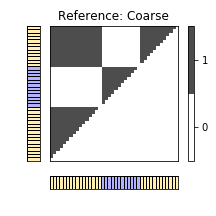
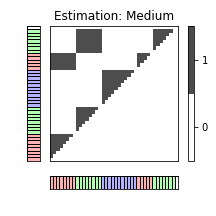
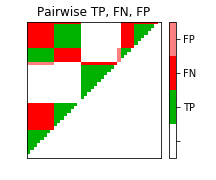

#TP =  226 ;  #FN =  218 ;  #FP =  12
P = 0.950;  R = 0.509;  F = 0.663



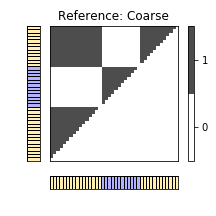
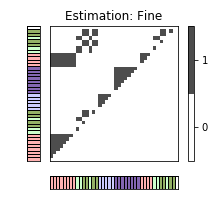
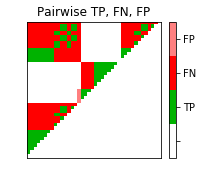

#TP =  143 ;  #FN =  301 ;  #FP =  4
P = 0.973;  R = 0.322;  F = 0.484



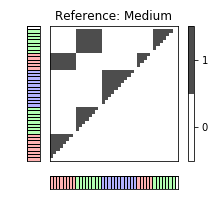
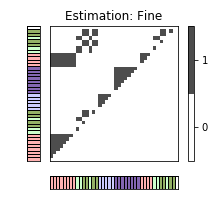
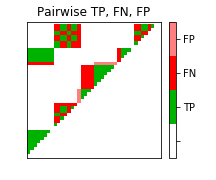

#TP =  136 ;  #FN =  102 ;  #FP =  11
P = 0.925;  R = 0.571;  F = 0.706


In [7]:
X_0 = convert_ann_to_seq_label(ann_Brahms[0])
X_1 = convert_ann_to_seq_label(ann_Brahms[1])
X_2 = convert_ann_to_seq_label(ann_Brahms[2])

X_set = [X_0, X_1, X_2]
combinations = [(0,1), (0,2), (1,2)]
case_label = ['Coarse', 'Medium', 'Fine']

for c in combinations:
    X_ref = X_set[c[0]]
    X_est = X_set[c[1]]
    
    float_box = libfmp.b.FloatingBox(align='top')
    I_ref_pos = compare_pairwise(X_ref)
    fig, ax = plot_matrix_label(I_ref_pos, X_ref, color_label=color_ann_Brahms, print_labels=False)
    ax[0,1].set_title('Reference: '+case_label[c[0]])
    float_box.add_fig(fig)

    I_est_pos = compare_pairwise(X_est)
    fig, ax = plot_matrix_label(I_est_pos, X_est, color_label=color_ann_Brahms, print_labels=False)
    ax[0,1].set_title('Estimation: '+case_label[c[1]])
    float_box.add_fig(fig)

    P, R, F, num_TP, num_FN, num_FP, I_eval =  evaluate_pairwise(I_ref_pos, I_est_pos)
    fig, im = plot_matrix_pairwise(I_eval)
    plt.title('Pairwise TP, FN, FP')
    float_box.add_fig(fig)

    float_box.show()

    print('#TP = ', num_TP, ';  #FN = ', num_FN, ';  #FP = ', num_FP)
    print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))

## Boundary Evaluation

The pairwise precision, recall, and F-measure are solely based on label information, whereas segment boundaries are treated implicitly by the presence of label changes. For other structure analysis tasks such as novelty-based segmentation, the precise detection of boundaries is the focus. To evaluate such procedures, one measures the deviation of the estimated segment boundaries from the boundaries of a reference annotation. To mathematically model this scenario, we introduce the notion of a **boundary annotation**, which is given by a sequence 

$$B=(b_1,b_2,\ldots,b_K)$$ 

of increasing indices $b_k\in[1:N]$, $k\in[1:K]$. For example, such a boundary annotation may be derived from a structure annotation by taking the start and possibly the end indices of the annotated segments. In the following, let $B^\mathrm{Ref}$ be the reference boundary annotation and $B^\mathrm{Est}$ the estimated boundary annotation. There are many ways to compare $B^\mathrm{Est}$ against $B^\mathrm{Ref}$. For example, using $\mathcal{I}=[1:N]$ as a set of items, one can define $\mathcal{I}^\mathrm{Ref}_+:=B^\mathrm{Ref}$ and $\mathcal{I}^\mathrm{Est}_+:=B^\mathrm{Est}$. From this, the precision, recall, and F-measure can be computed in the usual way. In this case, an estimated boundary is considered correct only if it agrees with a reference boundary. 

For certain applications small deviations in the boundary positions are acceptable. Therefore, one generalizes the previous measures by introducing a tolerance parameter $\tau\geq 0$ for the maximal acceptable deviation. An estimated boundary $b^\mathrm{Est}\in B^\mathrm{Est}$ is then considered **correct** if it lies within the $\tau$-neighborhood of a reference boundary $b^\mathrm{Ref}\in B^\mathrm{Ref}$:

\begin{equation}
   |b^\mathrm{Est}-b^\mathrm{Ref}|\leq \tau.
\end{equation}

In this case, the sets $\mathcal{I}^\mathrm{Ref}_+$ and $\mathcal{I}^\mathrm{Est}_+$ can no longer be used for defining precision and recall. Instead, we generalize the notions of true positives, false positives, and false negatives. The **true positives** (TP) are defined to be the items $b^\mathrm{Est}\in B^\mathrm{Est}$ that are correct, and the **false positives** (FP) are the items $b^\mathrm{Est}\in B^\mathrm{Est}$ that are not correct. Furthermore, the **false negatives** (FN) are defined to be the items $b^\mathrm{Ref}\in B^\mathrm{Ref}$ with no estimated item in a $\tau$-neighborhood. Based on these definitions, one can compute precision, recall, and F-measure from $\#\mathrm{TP}$, $\#\mathrm{FP}$, and $\#\mathrm{FN}$ as before.

However, this generalization needs to be taken with care. Because of the tolerance parameter $\tau$, several estimated boundaries may be contained in the $\tau$-neighborhood of a single reference boundary. Conversely, a single estimated boundary may be contained in the $\tau$-neighborhood of several reference boundaries. As a result, one may obtain a perfect F-measure even in the case that the sets $B^\mathrm{Est}$ and $B^\mathrm{Ref}$ contain a different number of boundaries. From a semantic point of view, this is not meaningful. To avoid such anomalies, one may introduce an additional assumption in the definition of a boundary annotation by requiring

\begin{equation}
   |b_{k+1}-b_k| > 2\tau
\end{equation}

for $k\in[1:N-1]$. This is also a meaningful requirement from a musical point of view: a musical section (determined by two subsequent boundaries) should be much longer than the size of the tolerance parameter. The following figure illustrates the boundary evaluation measures by means of a simple example. 

<!--
<ol type="a">
  <li type="a">Reference boundary annotation.</li>
  <li type="a">Estimated boundary annotation.</li>
  <li type="a">Evaluation of (b) with regard to (a).</li>
  <li type="a">$\tau$-Neighborhood of (a) using the tolerance parameter $\tau=1$.</li>
  <li type="a">Evaluation of (b) with regard to (d).</li>
  <li type="a">$\tau$-Neighborhood of (a) using the tolerance parameter $\tau=2$.</li>
  <li type="a">Evaluation of (b) with regard to (f).</li>    
</ol> 
-->

<img src="../data/C4/FMP_C4_F31_text.png" width="700px" align="middle" alt="FMP_C4_F31_text">

* Using the tolerance parameter $\tau=0$ (see (c)), one obtains $\#\mathrm{TP}=1$, $\#\mathrm{FP}=3$, and $\#\mathrm{FN}=2$. This yields $\mathrm{P}=1/4$, $\mathrm{R}=1/3$, and $\mathrm{F}=2/7$. 

* In the case $\tau=1$ (see (e)), one obtains $\#\mathrm{TP}=2$, $\#\mathrm{FP}=2$, and $\#\mathrm{FN}=1$, which results in $\mathrm{P}=1/2$, $\mathrm{R}=2/3$, and $\mathrm{F}=4/7$.

* Finally, when using $\tau=2$ (see (g)), one obtains a perfect F-measure. However, in this case the minimal distance condition is violated and the meaning of the evaluation measure is questionable.

====== Evaluation using tau = 0 ======
#TP =  1 ;  #FN =  2 ;  #FP =  3
P = 0.250;  R = 0.333;  F = 0.286


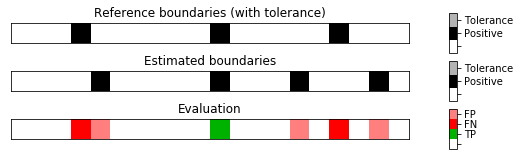

====== Evaluation using tau = 1 ======
#TP =  2 ;  #FN =  1 ;  #FP =  2
P = 0.500;  R = 0.667;  F = 0.571


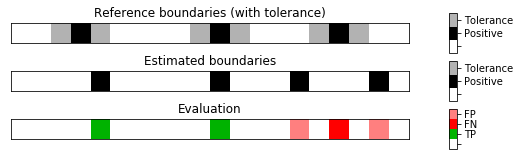

====== Evaluation using tau = 2 ======
#TP =  4 ;  #FN =  0 ;  #FP =  0
P = 1.000;  R = 1.000;  F = 1.000


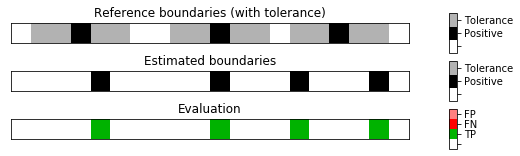

In [8]:
def evaluate_boundary(B_ref, B_est, tau):
    """Compute boundary evaluation measures [FMP, Section 4.5.4]

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        B_ref (np.ndarray): Reference boundary annotations
        B_est (np.ndarray): Estimated boundary annotations
        tau (int): Tolerance parameter.
            Note: Condition ``|b_{k+1}-b_k|>2tau`` should be fulfilled [FMP, Eq. 4.58]

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
        B_tol (np.ndarray): Data structure encoding B_ref with tolerance
        I_eval (np.ndarray): Data structure encoding TP, FN, FP
    """
    N = len(B_ref)
    num_TP = 0
    num_FN = 0
    num_FP = 0
    B_tol = np.zeros((np.array([B_ref])).shape)
    B_eval = np.zeros((np.array([B_ref])).shape)
    for n in range(N):
        min_idx = max(0, n - tau)
        max_idx = min(N - 1, n + tau)
        if B_ref[n] == 1:
            B_tol[:, min_idx:max_idx+1] = 2
            B_tol[:, n] = 1
            temp = sum(B_est[min_idx:max_idx+1])
            if temp > 0:
                num_TP += temp
            else:
                num_FN += 1
                B_eval[:, n] = 2
        if B_est[n] == 1:
            if sum(B_ref[min_idx:max_idx+1]) == 0:
                num_FP += 1
                B_eval[:, n] = 3
            else:
                B_eval[:, n] = 1
    P, R, F = measure_prf(num_TP, num_FN, num_FP)
    return P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval

def plot_boundary_measures(B_ref, B_est, tau, figsize=(8, 2.5)):
    """Plot B_ref and B_est (see :func:`libfmp.c4.c4s5_evaluation.evaluate_boundary`)

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        B_ref: Reference boundary annotations
        B_est: Estimated boundary annotations
        tau: Tolerance parameter
        figsize: Figure size (Default value = (8, 2.5))

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval = evaluate_boundary(B_ref, B_est, tau)

    colorList = np.array([[1., 1., 1., 1.], [0., 0., 0., 1.], [0.7, 0.7, 0.7, 1.]])
    cmap_tol = ListedColormap(colorList)
    colorList = np.array([[1, 1, 1, 1], [0, 0.7, 0, 1], [1, 0, 0, 1], [1, 0.5, 0.5, 1]])
    cmap_measures = ListedColormap(colorList)

    fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.02],
                                              'wspace': 0.2, 'height_ratios': [1, 1, 1]},
                           figsize=figsize)

    im = ax[0, 0].imshow(B_tol, cmap=cmap_tol, interpolation='nearest')
    ax[0, 0].set_title('Reference boundaries (with tolerance)')
    im.set_clim(vmin=-0.5, vmax=2.5)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[0, 1])
    ax_cb.set_ticks(np.arange(0, 3, 1))
    ax_cb.set_ticklabels(['', 'Positive', 'Tolerance'])

    im = ax[1, 0].imshow(np.array([B_est]), cmap=cmap_tol, interpolation='nearest')
    ax[1, 0].set_title('Estimated boundaries')
    im.set_clim(vmin=-0.5, vmax=2.5)
    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[1, 1])
    ax_cb.set_ticks(np.arange(0, 3, 1))
    ax_cb.set_ticklabels(['', 'Positive', 'Tolerance'])

    im = ax[2, 0].imshow(B_eval, cmap=cmap_measures, interpolation='nearest')
    ax[2, 0].set_title('Evaluation')
    im.set_clim(vmin=-0.5, vmax=3.5)
    ax[2, 0].set_xticks([])
    ax[2, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[2, 1])
    ax_cb.set_ticks(np.arange(0, 4, 1))
    ax_cb.set_ticklabels(['', 'TP', 'FN', 'FP'])
    plt.show()
    return fig, ax


B_ref = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
B_est = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
tau_list = [0,1,2]

for tau in tau_list:
    print('====== Evaluation using tau = %d ======'%tau)
    P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval = evaluate_boundary(B_ref, B_est, tau)    
    print('#TP = ', num_TP, ';  #FN = ', num_FN, ';  #FP = ', num_FP)
    print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))
    fig, ax = plot_boundary_measures(B_ref, B_est, tau=tau)



## Further Notes

Many evaluation measures involve some sort of precision and recall rate. We have seen some typical examples in this notebook. Here are some further links:

*  The [Python library `mir_eval`](https://craffel.github.io/mir_eval/) provides various standardized evaluation measures used in Music Information Retrieval (MIR). Additionally, the library also contains methods for the [visualization](../B/B_Annotations.html) and [sonification](../B/B_Sonification.html) of evaluation results.

* Systematic evaluations of different structure analysis methods have been performed over recent years within the [Music Information Retrieval Evaluation eXchange (MIREX) campaign](https://www.music-ir.org/mirex/wiki/MIREX_HOME), which provides a framework for evaluating various kinds of music processing algorithms. On the MIREX websites, one finds not only the evaluation results of numerous procedures, but also links to information on datasets, annotations, evaluation measures, and relevant literature. 


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>